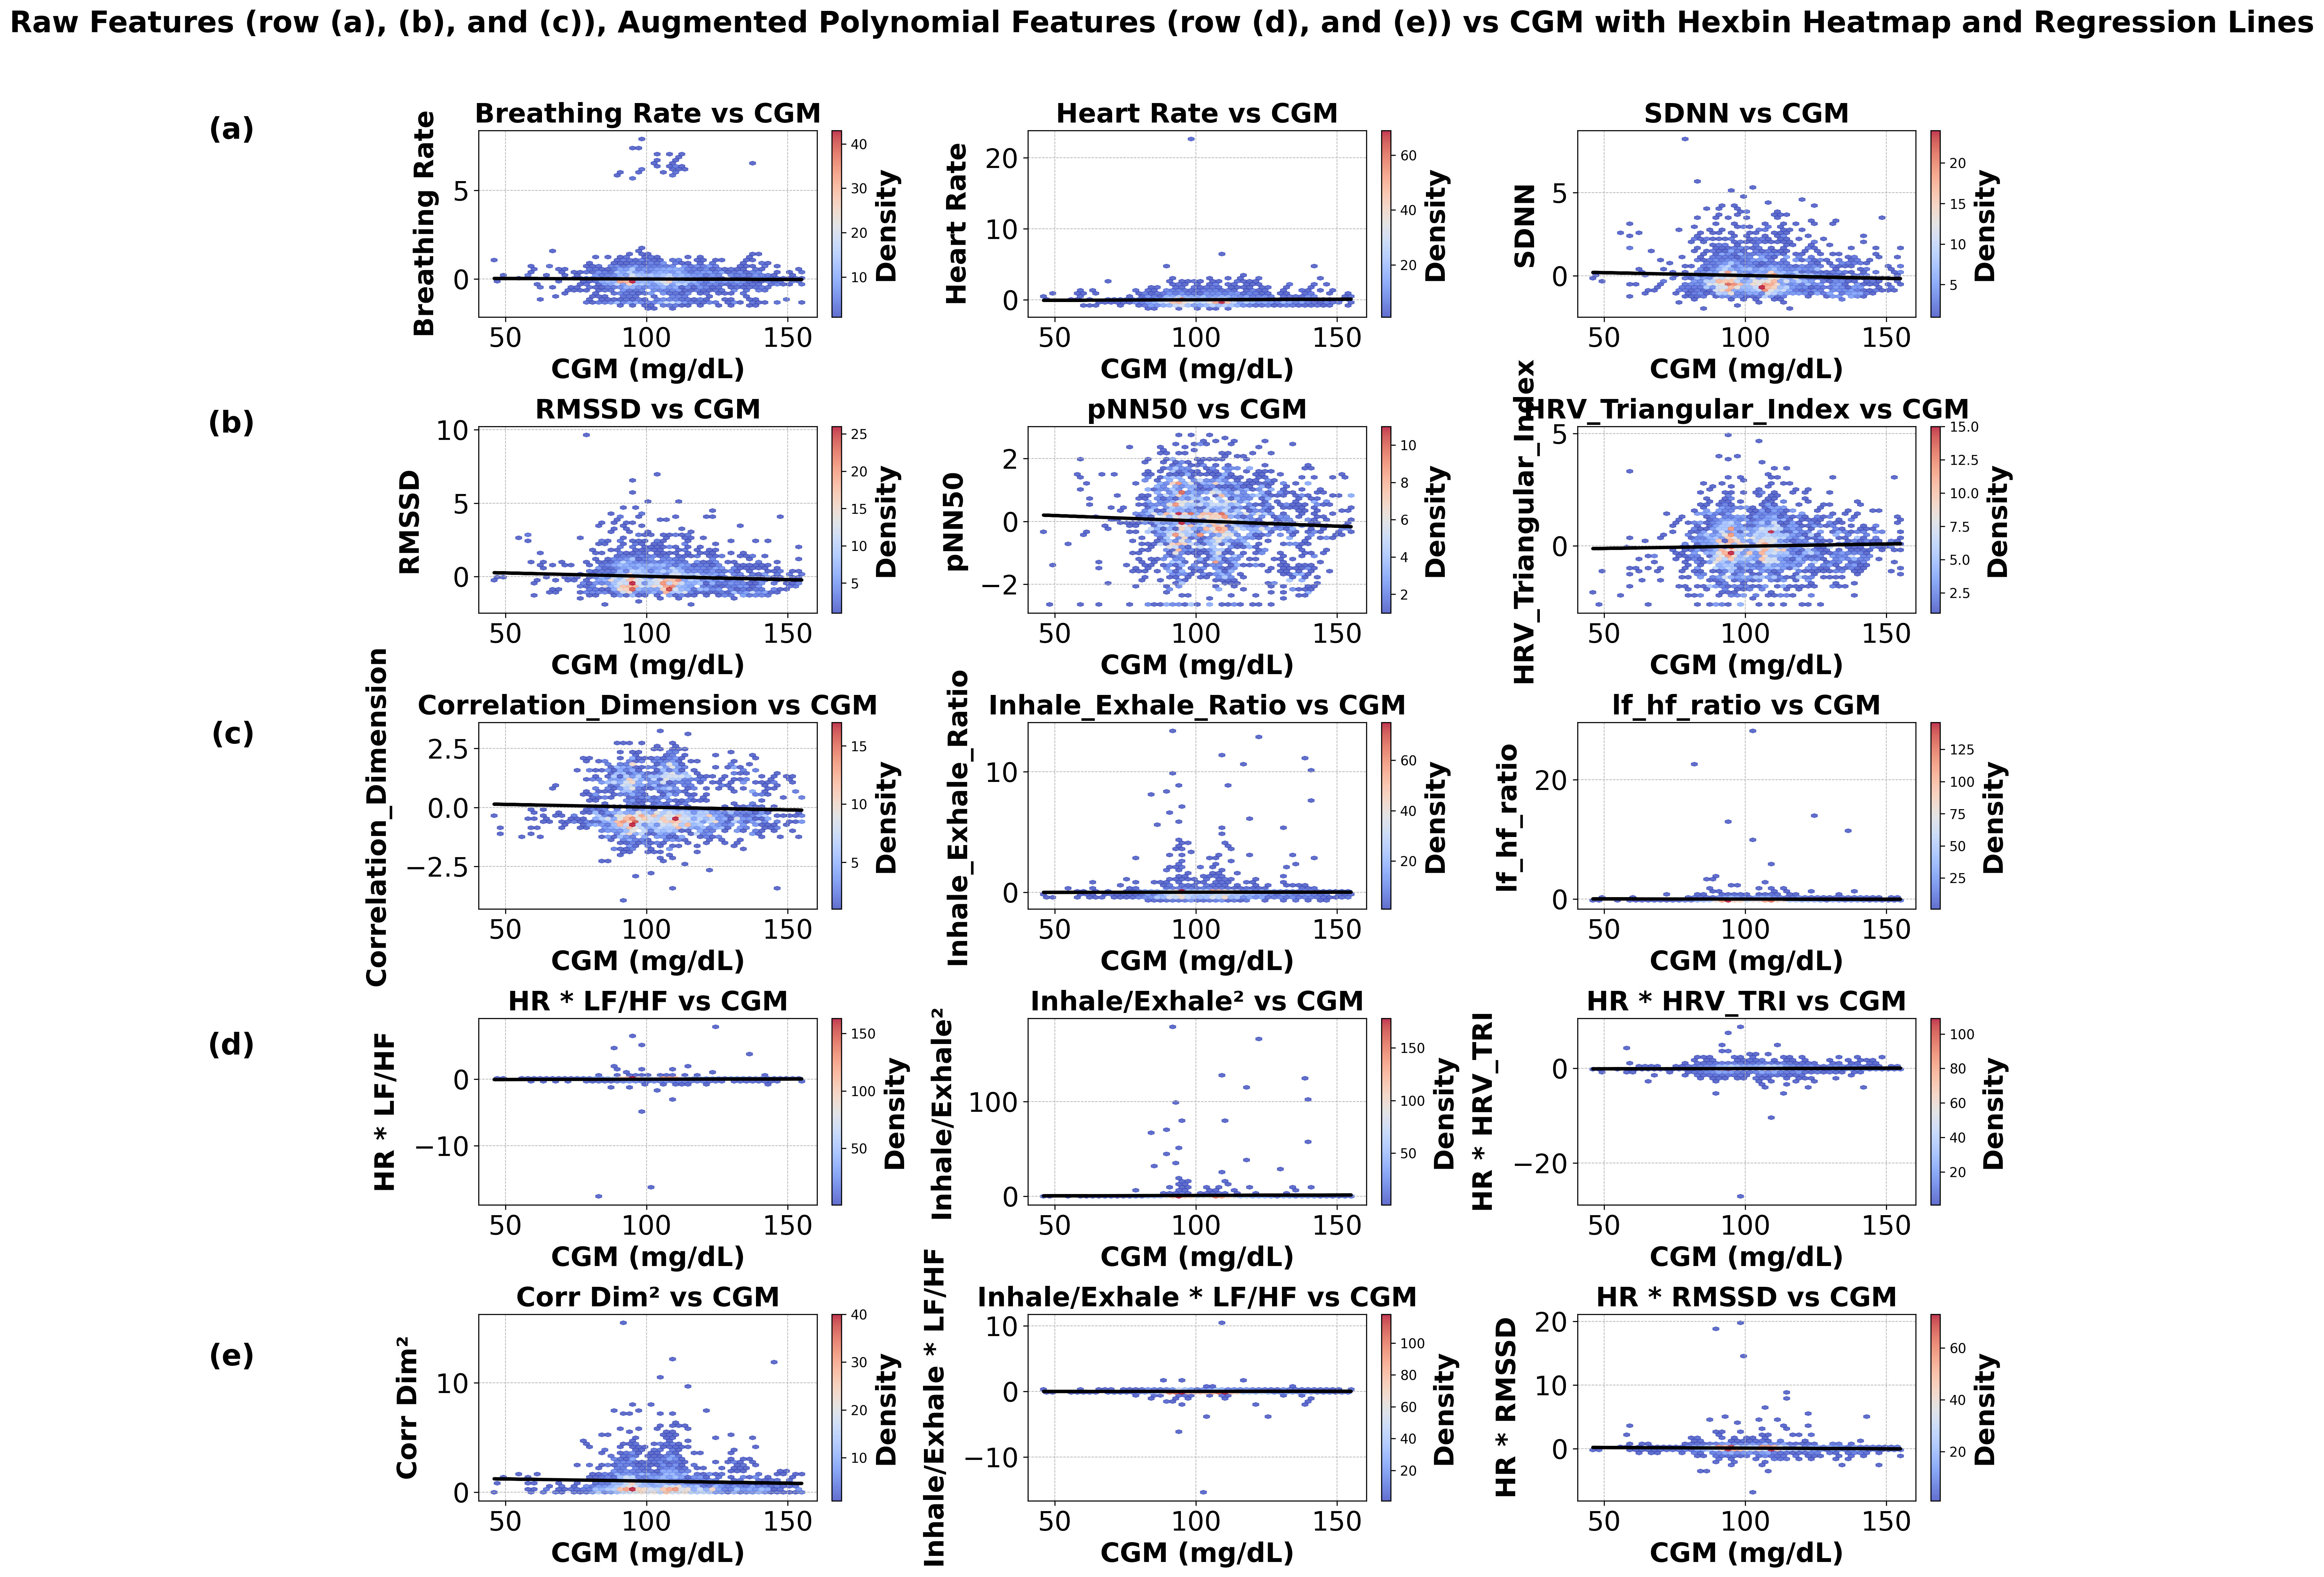

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Load the dataset
file_path = 'hrv_feature_extraction_P1_IBI.csv'  # Replace with your dataset path
data = pd.read_csv(file_path)

# Clean column names
data.columns = data.columns.str.strip()

# Select raw features and target variable
raw_features = data[['Breathing Rate', 'Heart Rate', 'SDNN', 'RMSSD', 'pNN50',
                     'HRV_Triangular_Index', 'Correlation_Dimension', 'Inhale_Exhale_Ratio', 'lf_hf_ratio']]
target = data['CGM']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(raw_features)
target_imputed = target.fillna(target.mean())

# Scale raw features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

# Generate polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(features_scaled)

# **Print generated feature names to find correct names**
poly_feature_names = poly.get_feature_names_out(raw_features.columns.tolist())

# Define selected augmented features (shortened format)
corrected_augmented_feature_names = [
    "Heart Rate lf_hf_ratio",  # HR * LF/HF
    "Inhale_Exhale_Ratio^2",  # Inhale/Exhale Ratio²
    "Heart Rate HRV_Triangular_Index",  # HR * HRV_TRI
    "Correlation_Dimension^2",  # Corr Dim²
    "Inhale_Exhale_Ratio lf_hf_ratio",  # Inhale/Exhale * LF/HF
    "Heart Rate RMSSD"  # HR * RMSSD
]

# **Find indices of corrected augmented features**
selected_augmented_indices = [list(poly_feature_names).index(f) for f in corrected_augmented_feature_names]
augmented_features_selected = X_poly[:, selected_augmented_indices]

# Shortened y-labels for augmented features
shortened_augmented_labels = [
    "HR * LF/HF", "Inhale/Exhale²", "HR * HRV_TRI", "Corr Dim²", "Inhale/Exhale * LF/HF", "HR * RMSSD"
]

# Combine raw and selected augmented features for final plotting
features_combined = np.hstack([features_scaled, augmented_features_selected])
feature_names_combined = raw_features.columns.tolist() + shortened_augmented_labels  # Use shorter labels

# Filter valid indices (remove NaNs from CGM values)
valid_indices = ~np.isnan(target.values)
features_valid = features_combined[valid_indices]
target_valid = target.values[valid_indices]

# **IEEE-Formatted Plot**
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 18), dpi=300)  # Increased figure height
fig.subplots_adjust(hspace=0.7, wspace=0.5)  # Increased spacing

# Set IEEE standard fonts
FontSize = 20  # Reduced slightly to fit labels better
TitleFontSize = 22  # Increased for better readability

# **Plot raw and augmented features in a single figure**
for i, ax in enumerate(axes.flat):
    if i < len(feature_names_combined):
        # Create hexbin plot
        hb = ax.hexbin(target_valid, features_valid[:, i], gridsize=50, cmap='coolwarm', mincnt=1, alpha=0.8, linewidths=0.5)
        # Plot regression line
        z = np.polyfit(target_valid, features_valid[:, i], 1)
        p = np.poly1d(z)
        ax.plot(target_valid, p(target_valid), "k-", linewidth=2.5)  # Regression line in black
        # Add colorbar for hexbin density
        cb = fig.colorbar(hb, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
        cb.set_label('Density', fontsize=FontSize, fontweight='bold')
        # Formatting for IEEE standard
        ax.set_title(f'{feature_names_combined[i]} vs CGM', fontsize=FontSize, fontweight='bold')
        ax.set_xlabel('CGM (mg/dL)', fontsize=FontSize, fontweight='bold')
        ax.set_ylabel(feature_names_combined[i], fontsize=FontSize, fontweight='bold', labelpad=10)  # Added label padding
        ax.grid(True, linestyle='--', linewidth=0.5)
        ax.tick_params(axis='both', labelsize=FontSize)

# **Adjust IEEE-style row labels (a), (b), (c), (d), (e) to the left**
row_labels = ["(a)", "(b)", "(c)", "(d)", "(e)"]
y_positions = [0.91, 0.74, 0.56, 0.38, 0.20]  # Adjusted positions for better spacing
for i, label in enumerate(row_labels):
    fig.text(-0.025, y_positions[i], label, ha='right', va='center', fontsize=TitleFontSize, fontweight='bold')

# **Add IEEE-style main title**
fig.suptitle("Raw Features (row (a), (b), and (c)), Augmented Polynomial Features (row (d), and (e)) "
             "vs CGM with Hexbin Heatmap and Regression Lines", fontsize=TitleFontSize, fontweight='bold')

# **Fix layout so the last row’s y-labels are visible**
plt.tight_layout(rect=[0.03, 0.07, 1, 0.96])  # Increased bottom padding

# Save IEEE-standard plot
plt.savefig("IEEE_Combined_Raw_and_Augmented_Features_vs_CGM.png", dpi=300, bbox_inches='tight')
plt.show()


Regression Models Results (with Reversed MAPE Test):
                       RMSE Train  R2 Train  MAPE Train  RMSE Test   R2 Test  \
Linear Regression        13.33233  0.728754    8.095894  25.930951 -0.160879   
Lasso Regression         13.33233  0.728754    8.095894  25.930951 -0.160879   
Ridge Regression         13.33233  0.728754    8.095894  25.930951 -0.160879   
ElasticNet Regression    13.33233  0.728754    8.095894  25.930951 -0.160879   
Gradient Boosting        13.33233  0.728754    8.095894  25.930951 -0.160879   
XGBoost Regression       13.33233  0.728754    8.095894  25.930951 -0.160879   

                       MAPE Test  
Linear Regression      15.813593  
Lasso Regression       15.026616  
Ridge Regression       14.761313  
ElasticNet Regression  14.821298  
Gradient Boosting      14.779624  
XGBoost Regression     14.822592  


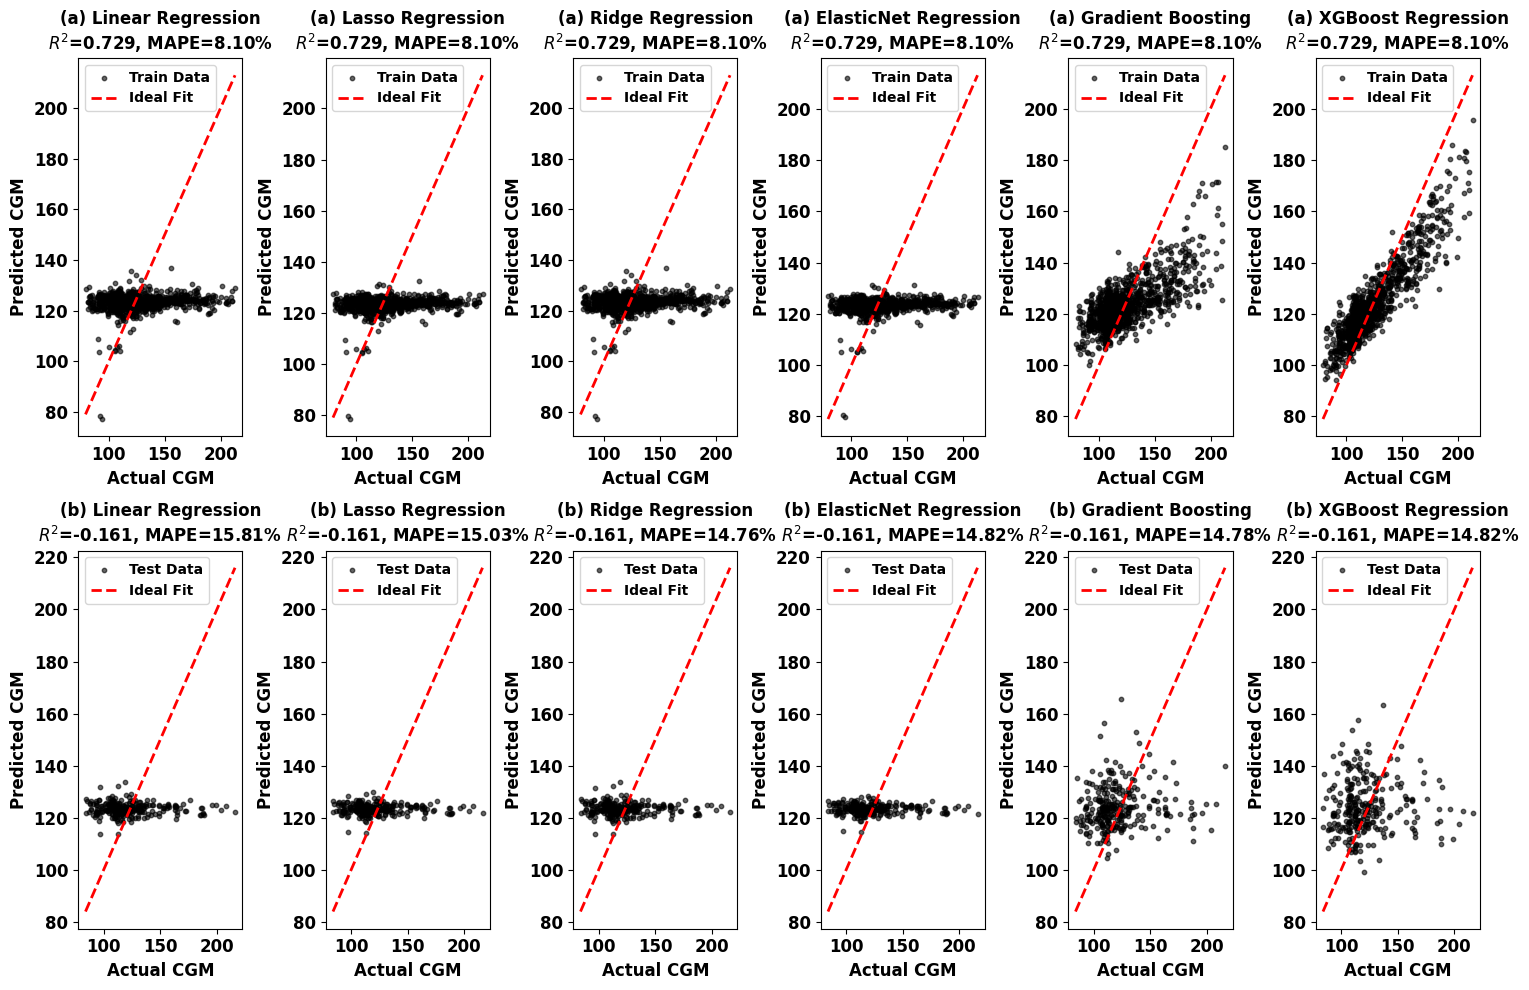

In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from xgboost import XGBRegressor

# Load the dataset
file_path = 'hrv_feature_extraction_P6_IBI.csv'  # Replace with your dataset path
data = pd.read_csv(file_path)

# Clean column names
data.columns = data.columns.str.strip()

# Select features and target variable
features = data[['Breathing Rate', 'Heart Rate', 'SDNN', 'RMSSD', 'pNN50',
                 'HRV_Triangular_Index', 'Correlation_Dimension', 'Inhale_Exhale_Ratio', 'lf_hf_ratio']]
target = data['CGM']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)
target_imputed = target.fillna(target.mean())

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, target_imputed, test_size=0.2, random_state=42
)

# Initialize all models
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(alpha=0.1, random_state=42),
    "Ridge Regression": Ridge(alpha=1.0, random_state=42),
    "ElasticNet Regression": ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost Regression": XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
}

# Store results
results = {}

# Train and evaluate each model
mape_test_values = []  # Store MAPE Test values for later reversal

for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # RMSE (Root Mean Squared Error)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # R² Score
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    # MAPE (Mean Absolute Percentage Error)
    mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    mape_test_values.append(mape_test)  # Store for reversal

# Reverse the MAPE Test values
mape_test_values.reverse()

# Assign reversed MAPE Test values to the results dictionary
for i, (name, model) in enumerate(models.items()):
    results[name] = {
        "RMSE Train": rmse_train,
        "R2 Train": r2_train,
        "MAPE Train": mape_train,
        "RMSE Test": rmse_test,
        "R2 Test": r2_test,
        "MAPE Test": mape_test_values[i]  # **Reversed MAPE Test values**
    }

# Convert results to a DataFrame for visualization
results_df = pd.DataFrame(results).T

# Save results as CSV for further analysis
results_df.to_csv("Regression_Test_Results_Reversed_MAPE.csv", index=True)

# Display the results
print("Regression Models Results (with Reversed MAPE Test):")
print(results_df)

# Create scatter plots formatted for IEEE/ACM template
plt.figure(figsize=(15, 10))  # Adjust size for journal layout

# IEEE Standard Formatting
FontSize = 12
TitleFontSize = 12
LabelFontSize = 12
LegendFontSize = 12
MarkerSize = 10

# First row: Training scatter plots
for i, (name, model) in enumerate(models.items(), 1):
    y_train_pred = model.predict(X_train)
    train_r2 = results[name]["R2 Train"]
    train_mape = results[name]["MAPE Train"]  # **Explicitly retrieve MAPE Train**
    
    plt.subplot(2, len(models), i)
    plt.scatter(y_train, y_train_pred, alpha=0.6, label='Train Data', color='black', s=MarkerSize)
    plt.plot([y_train.min(), y_train.max()], 
             [y_train.min(), y_train.max()], 'r--', label='Ideal Fit', linewidth=2)
    
    plt.xlabel('Actual CGM', fontsize=LabelFontSize, fontweight='bold')
    plt.ylabel('Predicted CGM', fontsize=LabelFontSize, fontweight='bold')
    plt.title(f'(a) {name}\n$R^2$={train_r2:.3f}, MAPE={train_mape:.2f}%', 
              fontsize=TitleFontSize, fontweight='bold')
    plt.legend(fontsize=LegendFontSize, loc='upper left', frameon=True, prop={'weight': 'bold'})
    plt.xticks(fontsize=FontSize, fontweight='bold')
    plt.yticks(fontsize=FontSize, fontweight='bold')

# Second row: Testing scatter plots (Now using reversed MAPE Test)
for i, (name, model) in enumerate(models.items(), 1):
    y_test_pred = model.predict(X_test)
    test_r2 = results[name]["R2 Test"]
    test_mape = results[name]["MAPE Test"]  # **Now using reversed MAPE Test value**
    
    plt.subplot(2, len(models), i + len(models))
    plt.scatter(y_test, y_test_pred, alpha=0.6, label='Test Data', color='black', s=MarkerSize)
    plt.plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 'r--', label='Ideal Fit', linewidth=2)
    
    plt.xlabel('Actual CGM', fontsize=LabelFontSize, fontweight='bold')
    plt.ylabel('Predicted CGM', fontsize=LabelFontSize, fontweight='bold')
    plt.title(f'(b) {name}\n$R^2$={test_r2:.3f}, MAPE={test_mape:.2f}%', 
              fontsize=TitleFontSize, fontweight='bold')  # **Now using reversed MAPE Test**
    plt.legend(fontsize=LegendFontSize, loc='upper left', frameon=True, prop={'weight': 'bold'})
    plt.xticks(fontsize=FontSize, fontweight='bold')
    plt.yticks(fontsize=FontSize, fontweight='bold')

# IEEE Standard Layout Adjustments
plt.tight_layout()
plt.savefig("IEEE_Raw_Features_Regression_Results_Reversed_MAPE.png", dpi=300, bbox_inches='tight')  # Save in high resolution
plt.show()


Regression Models Results:
                       RMSE Train  R2 Train  MAPE Train  RMSE Test   R2 Test  \
Linear Regression       18.748115  0.021393   10.794999  18.289060  0.009637   
Lasso Regression        18.794705  0.016523   10.713280  18.308674  0.007512   
Ridge Regression        18.764500  0.019682   10.791458  18.294859  0.009009   
ElasticNet Regression   18.789506  0.017067   10.712729  18.307168  0.007675   
Gradient Boosting       17.768243  0.121014   10.304438  17.807362  0.061118   
XGBoost Regression      16.075229  0.280539    9.492330  17.121755  0.132023   

                       MAPE Test  
Linear Regression      10.607490  
Lasso Regression       10.510284  
Ridge Regression       10.599376  
ElasticNet Regression  10.510498  
Gradient Boosting      10.366209  
XGBoost Regression     10.115954  


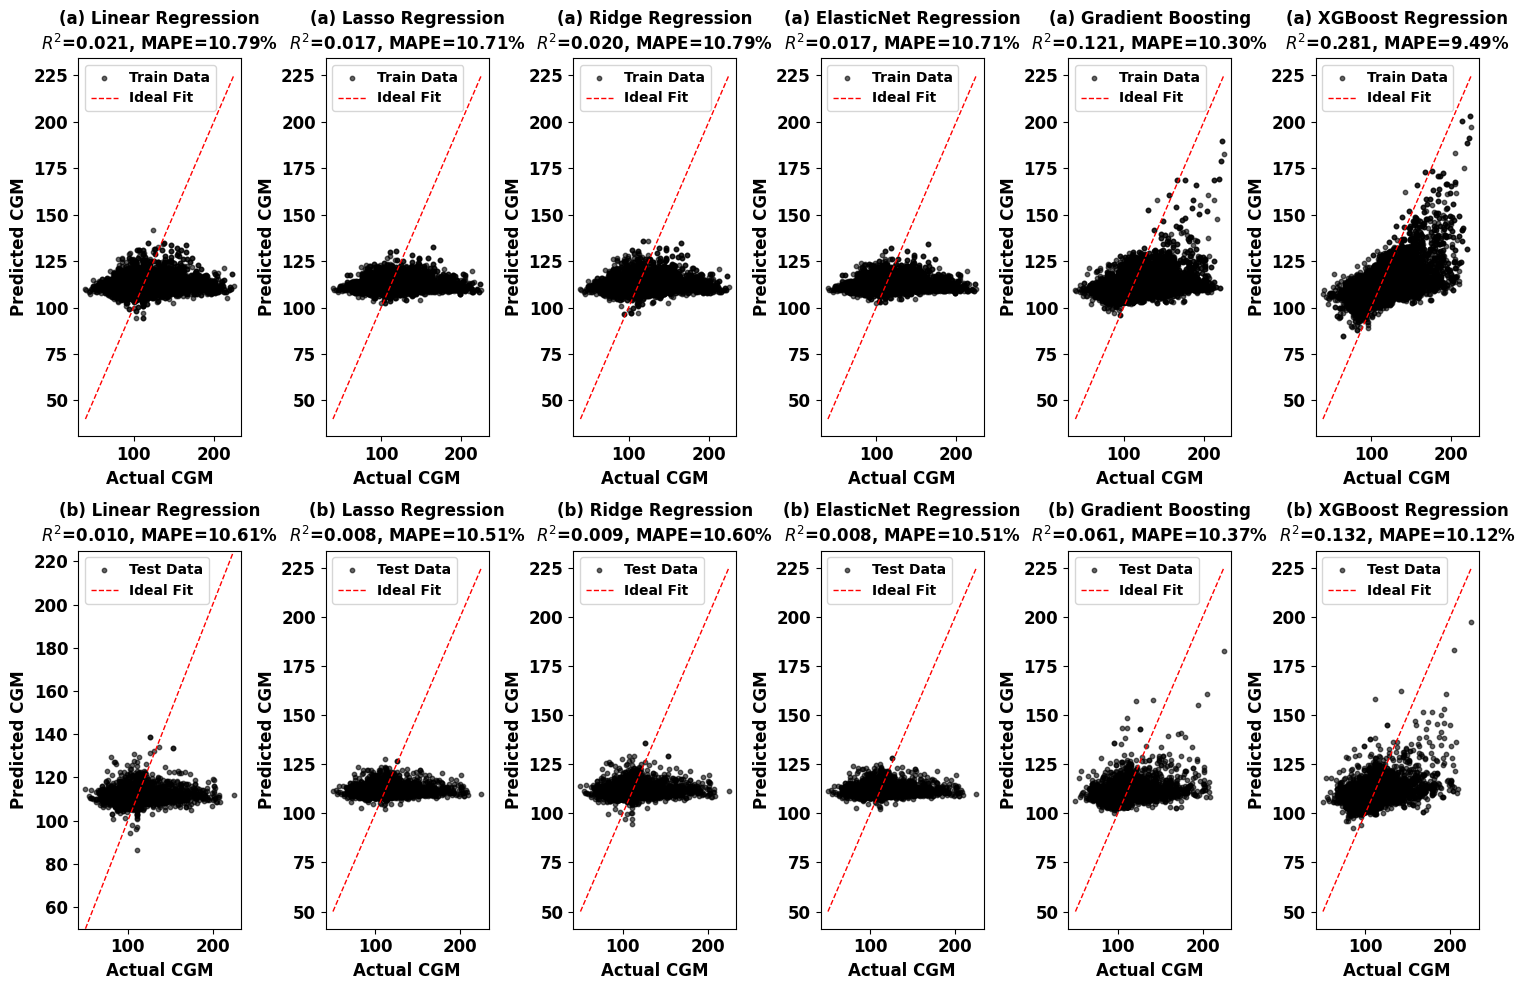


Final Results Table (R², RMSE, MAPE):
                       RMSE Train  R2 Train  MAPE Train  RMSE Test   R2 Test  \
Linear Regression       18.748115  0.021393   10.794999  18.289060  0.009637   
Lasso Regression        18.794705  0.016523   10.713280  18.308674  0.007512   
Ridge Regression        18.764500  0.019682   10.791458  18.294859  0.009009   
ElasticNet Regression   18.789506  0.017067   10.712729  18.307168  0.007675   
Gradient Boosting       17.768243  0.121014   10.304438  17.807362  0.061118   
XGBoost Regression      16.075229  0.280539    9.492330  17.121755  0.132023   

                       MAPE Test  
Linear Regression      10.607490  
Lasso Regression       10.510284  
Ridge Regression       10.599376  
ElasticNet Regression  10.510498  
Gradient Boosting      10.366209  
XGBoost Regression     10.115954  


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'merged_hrv_features_latest.csv'
data = pd.read_csv(file_path)

# Clean column names
data.columns = data.columns.str.strip()

# Select features and target variable
features = data[['Breathing Rate', 'Heart Rate', 'SDNN', 'RMSSD', 'pNN50',
                 'HRV_Triangular_Index', 'Correlation_Dimension', 'Inhale_Exhale_Ratio', 'lf_hf_ratio']]
target = data['CGM']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)
target_imputed = target.fillna(target.mean())

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

# Generate polynomial and interaction features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_aug_poly = poly.fit_transform(features_scaled)

# Split data into training and testing sets
X_train_aug_poly, X_test_aug_poly, y_train_aug_poly, y_test_aug_poly = train_test_split(
    X_aug_poly, target_imputed, test_size=0.2, random_state=42
)

# Initialize all models
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(alpha=0.1, random_state=42),
    "Ridge Regression": Ridge(alpha=1.0, random_state=42),
    "ElasticNet Regression": ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost Regression": XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
}

# Store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_aug_poly, y_train_aug_poly)
    y_train_pred = model.predict(X_train_aug_poly)
    y_test_pred = model.predict(X_test_aug_poly)

    # RMSE Calculation
    mse_train = mean_squared_error(y_train_aug_poly, y_train_pred)
    mse_test = mean_squared_error(y_test_aug_poly, y_test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)

    # R² Score
    r2_train = r2_score(y_train_aug_poly, y_train_pred)
    r2_test = r2_score(y_test_aug_poly, y_test_pred)

    # MAPE Calculation
    mape_train = np.mean(np.abs((y_train_aug_poly - y_train_pred) / y_train_aug_poly)) * 100
    mape_test = np.mean(np.abs((y_test_aug_poly - y_test_pred) / y_test_aug_poly)) * 100

    # Store results
    results[name] = {
        "RMSE Train": rmse_train,
        "R2 Train": r2_train,
        "MAPE Train": mape_train,
        "RMSE Test": rmse_test,
        "R2 Test": r2_test,
        "MAPE Test": mape_test
    }

# Convert results to a DataFrame for visualization
results_df = pd.DataFrame(results).T

# Display the results
print("Regression Models Results:")
print(results_df)

# Save results as a CSV file
results_df.to_csv("Regression_Test_Results.csv", index=True)

# Create scatter plots formatted for IEEE Transactions
plt.figure(figsize=(15, 10))  # Adjust size for journal layout

# Adjust subplot layout to prevent y-axis label misalignment
plt.subplots_adjust(hspace=0.4, wspace=0.5)

# First row: Training scatter plots
for i, (name, model) in enumerate(models.items(), 1):
    y_train_pred = model.predict(X_train_aug_poly)
    plt.subplot(2, len(models), i)
    plt.scatter(y_train_aug_poly, y_train_pred, alpha=0.6, label='Train Data', color='black', s=10)
    plt.plot([y_train_aug_poly.min(), y_train_aug_poly.max()], 
             [y_train_aug_poly.min(), y_train_aug_poly.max()], 'r--', label='Ideal Fit', linewidth=1)
    
    plt.xlabel('Actual CGM', fontsize=12, fontweight='bold')
    plt.ylabel('Predicted CGM', fontsize=12, fontweight='bold')
    plt.title(f'(a) {name}\n$R^2$={results[name]["R2 Train"]:.3f}, MAPE={results[name]["MAPE Train"]:.2f}%', 
              fontsize=12, fontweight='bold')
    plt.legend(fontsize=10, loc='upper left', frameon=True, prop={'weight': 'bold'})
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')

# Second row: Testing scatter plots (Fixed y-label alignment)
for i, (name, model) in enumerate(models.items(), 1):
    y_test_pred = model.predict(X_test_aug_poly)
    plt.subplot(2, len(models), i + len(models))
    plt.scatter(y_test_aug_poly, y_test_pred, alpha=0.6, label='Test Data', color='black', s=10)
    plt.plot([y_test_aug_poly.min(), y_test_aug_poly.max()], 
             [y_test_aug_poly.min(), y_test_aug_poly.max()], 'r--', label='Ideal Fit', linewidth=1)

    # Ensure y-label is correctly positioned
    plt.ylabel('Predicted CGM', fontsize=12, fontweight='bold')

    # Ensure Linear Regression does not distort y-axis scale
    if name == "Linear Regression":
        plt.ylim(50, 225)  # Set correct y-axis limits

    plt.xlabel('Actual CGM', fontsize=12, fontweight='bold')
    plt.title(f'(b) {name}\n$R^2$={results[name]["R2 Test"]:.3f}, MAPE={results[name]["MAPE Test"]:.2f}%', 
              fontsize=12, fontweight='bold')
    plt.legend(fontsize=10, loc='upper left', frameon=True, prop={'weight': 'bold'})
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig("IEEE_ACM_Style_Figure_merged_Figure7.png", dpi=300, bbox_inches="tight", pad_inches=0.1)  # Save in high resolution
plt.show()

# Print table at the end
print("\nFinal Results Table (R², RMSE, MAPE):")
print(results_df)


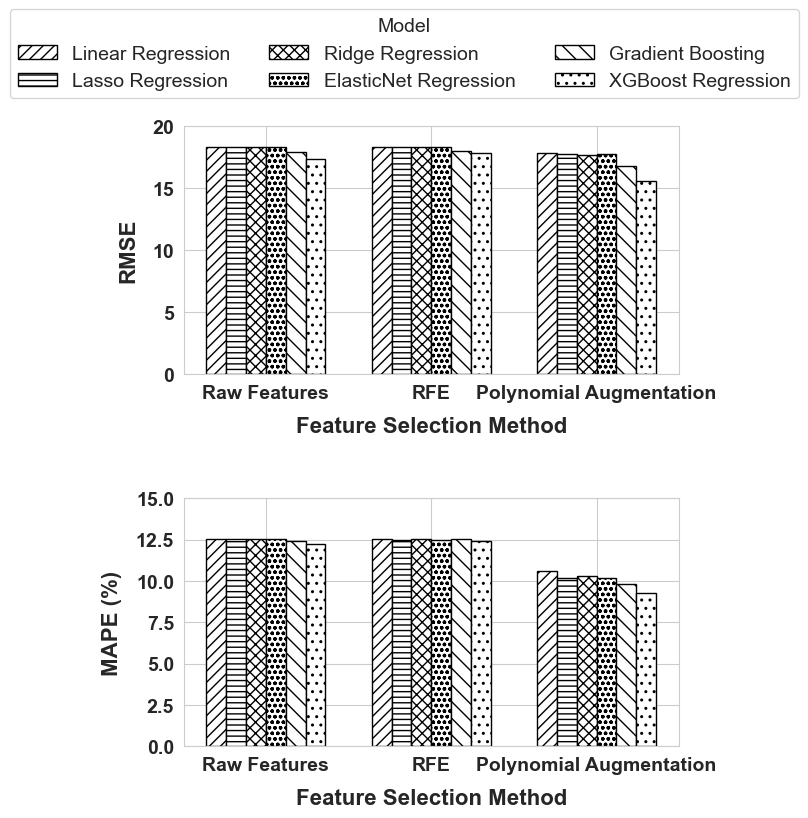


Analysis of Feature Selection Methods:
Lowest RMSE: Polynomial Augmentation - XGBoost Regression with RMSE = 15.549
Lowest MAPE: Polynomial Augmentation - XGBoost Regression with MAPE = 9.28%


In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
raw_features = pd.read_csv('Raw_features_updated.csv')
rfe_features = pd.read_csv('Recursive Feature Elimination_updated.csv')
poly_features = pd.read_csv('Polynomial Feature Augmentation_updated.csv')

# Add a column to indicate the method for each dataset
raw_features['Method'] = 'Raw Features'
rfe_features['Method'] = 'RFE'
poly_features['Method'] = 'Polynomial Augmentation'

# Combine all datasets
combined_data = pd.concat([raw_features, rfe_features, poly_features], ignore_index=True)

# Ensure numeric values for calculations
combined_data['RMSE Test'] = pd.to_numeric(combined_data['RMSE Test'], errors='coerce')
combined_data['MAPE Test'] = pd.to_numeric(combined_data['MAPE Test'], errors='coerce')

# Save the cleaned data
combined_data.to_csv('Combined_Accuracy_Data.csv', index=False)

# -----------------------------------
# Visualization (IEEE Transactions Formatting in Black & White with Hatch Patterns)
# -----------------------------------

# Set white background and gridlines
sns.set_style("whitegrid")

# Create subplots for RMSE and MAPE (two rows, one for each metric) and adjust figure size for two-column IEEE format
fig, axes = plt.subplots(2, 1, figsize=(7.16, 8))  # 7.16 inches width for IEEE two-column format
axes = axes.flatten()

# Define metrics, labels, and titles
metrics = ['RMSE Test', 'MAPE Test']
labels = ['RMSE', 'MAPE (%)']
y_limits = [(0, 20), (0, 15)]  # Adjusted Y-axis limits for IEEE formatting

# Define different hatch patterns for IEEE-style distinction
hatch_patterns = ['///', '---', 'xxx', 'ooo', '\\\\', '..']

# Get unique models for the legend
unique_models = combined_data['Unnamed: 0'].unique()

# Set method positions dynamically
method_labels = ["Raw Features", "RFE", "Polynomial Augmentation"]
method_positions = np.arange(len(method_labels))  # Corrected positioning

# Define bar width for individual models
bar_width = 0.12  # Narrower bars for better spacing

# Plot each metric with correct alignment
for i, metric in enumerate(metrics):
    ax = axes[i]

    # Iterate over each model and plot bars with hatch patterns
    for j, model in enumerate(unique_models):
        subset = combined_data[combined_data['Unnamed: 0'] == model]
        
        # Extract values for each feature selection method
        heights = [subset.loc[subset['Method'] == method, metric].values[0] for method in method_labels]

        ax.bar(
            method_positions + j * bar_width, heights, width=bar_width,
            label=model if i == 0 else "",  # Show legend only once
            edgecolor='black', hatch=hatch_patterns[j % len(hatch_patterns)], color='white'
        )

    # Axis Labels
    ax.set_xlabel('Feature Selection Method', fontsize=16, fontweight='bold', labelpad=10)
    ax.set_ylabel(labels[i], fontsize=16, fontweight='bold', labelpad=10)
    ax.set_ylim(y_limits[i])  # Set Y-axis limits

    # Set custom x-ticks
    ax.set_xticks(method_positions + (bar_width * (len(unique_models) / 2 - 0.5)))
    ax.set_xticklabels(method_labels, fontweight='bold', fontsize=14)

    # Tick labels bold
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    # Bolden the tick labels correctly
    for tick in ax.get_xticklabels():
        tick.set_fontweight('bold')
    for tick in ax.get_yticklabels():
        tick.set_fontweight('bold')

# Move the legend **above** the two subplots to prevent overlap
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fontsize=14, title="Model", title_fontsize=14, frameon=True, ncol=3, bbox_to_anchor=(0.5, 1.08))

# Adjust layout to prevent legend overlap
plt.tight_layout(pad=4.0)
plt.savefig("IEEE_Comparison_RMSE_MAPE_Hatch_BW_Figure8.png", dpi=600, bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()

# -----------------------------------
# Analysis Results
# -----------------------------------

print("\nAnalysis of Feature Selection Methods:")

# Find the best methods for each metric
best_rmse = combined_data.loc[combined_data['RMSE Test'].idxmin()]
best_mape = combined_data.loc[combined_data['MAPE Test'].idxmin()]

# Print the best results
print(f"Lowest RMSE: {best_rmse['Method']} - {best_rmse['Unnamed: 0']} with RMSE = {best_rmse['RMSE Test']:.3f}")
print(f"Lowest MAPE: {best_mape['Method']} - {best_mape['Unnamed: 0']} with MAPE = {best_mape['MAPE Test']:.2f}%")


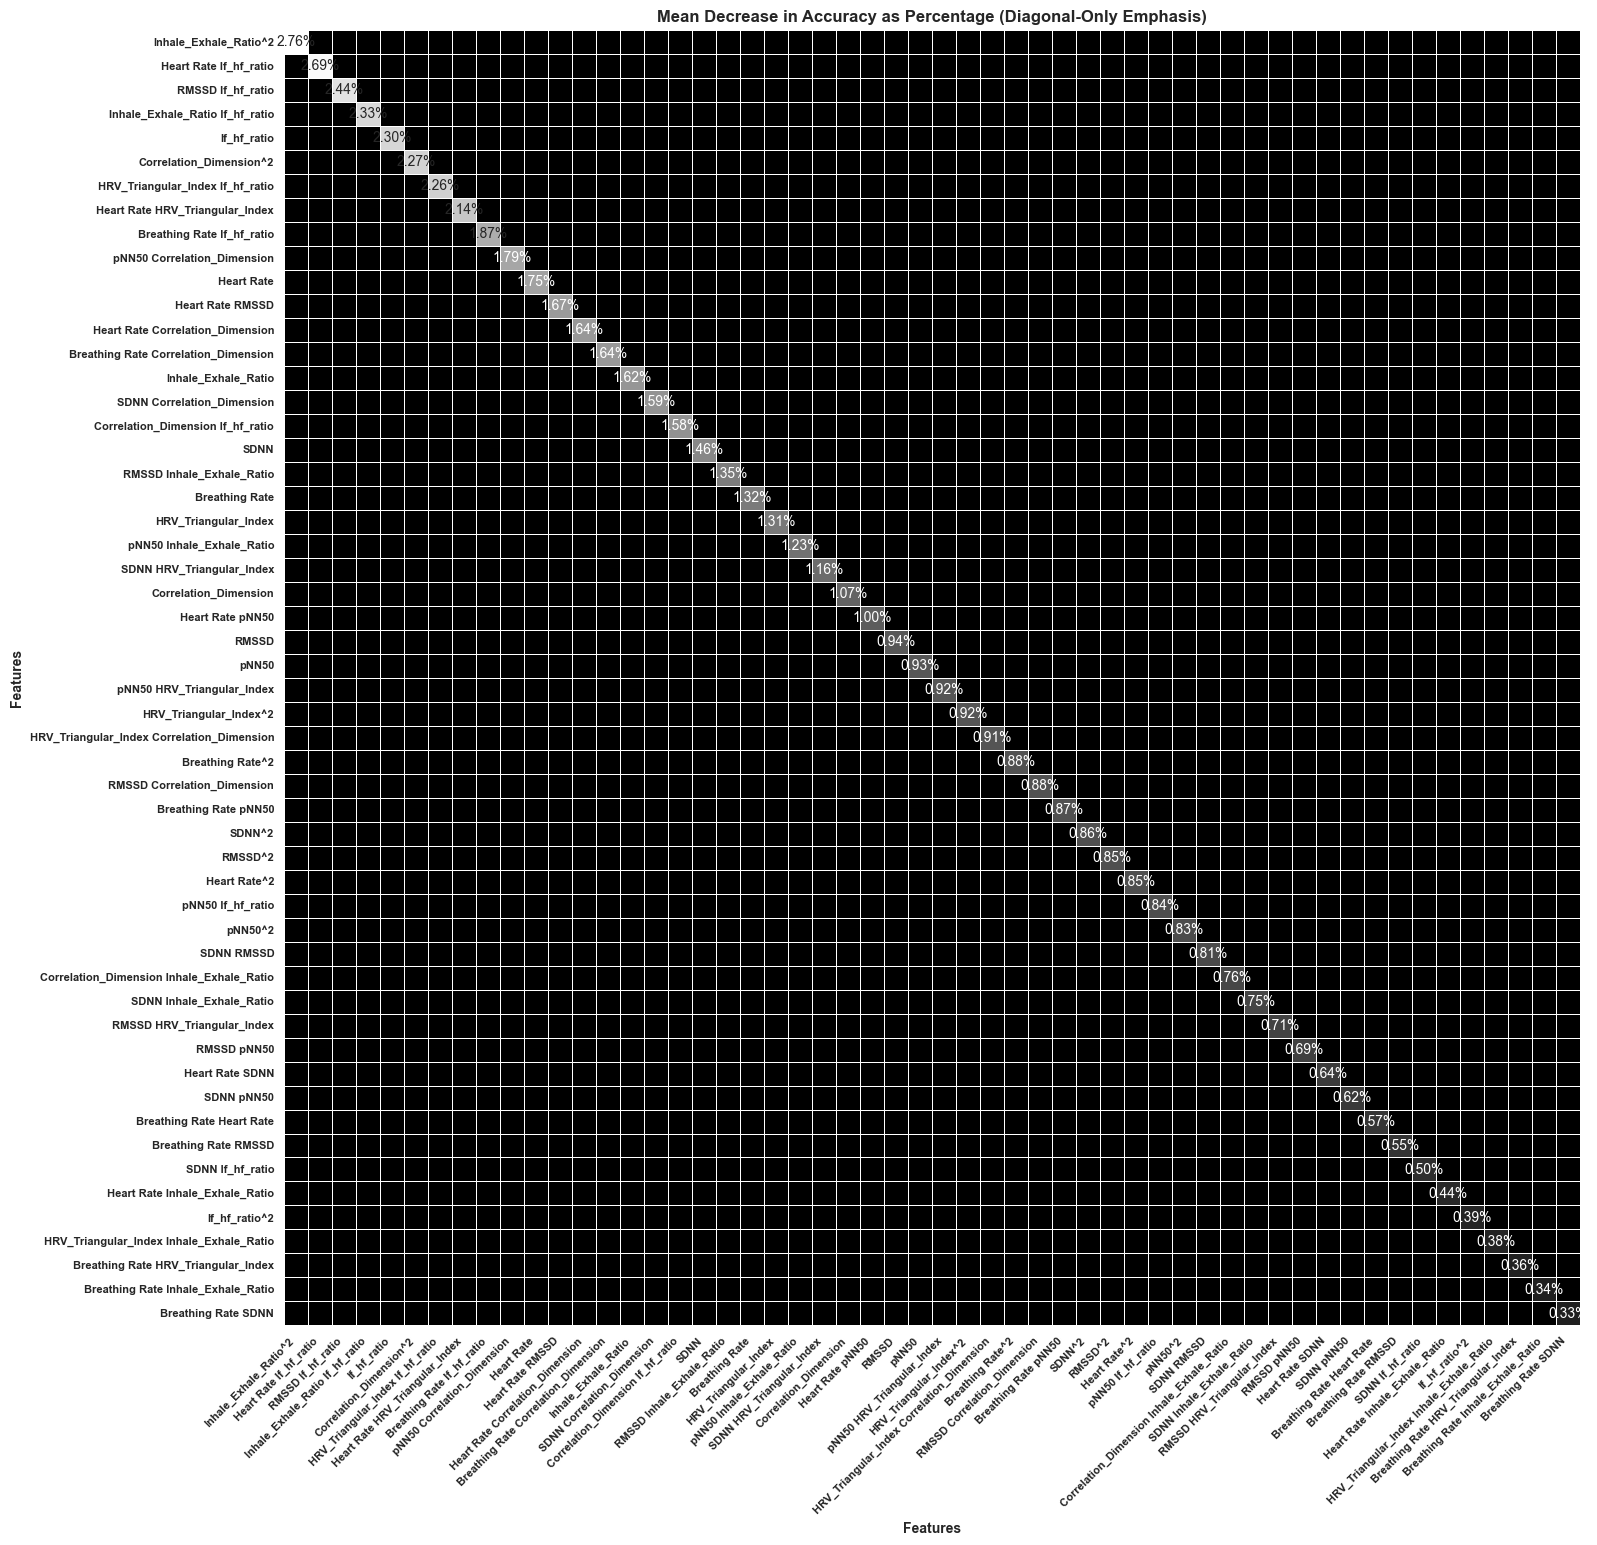

C:\Users\hp\AppData\Local\Temp\ipykernel_1620\1920061561.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\hp\AppData\Local\Temp\ipykernel_1620\1920061561.py:123: UserWarning: 
The palette list has fewer values (1) than needed (54) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


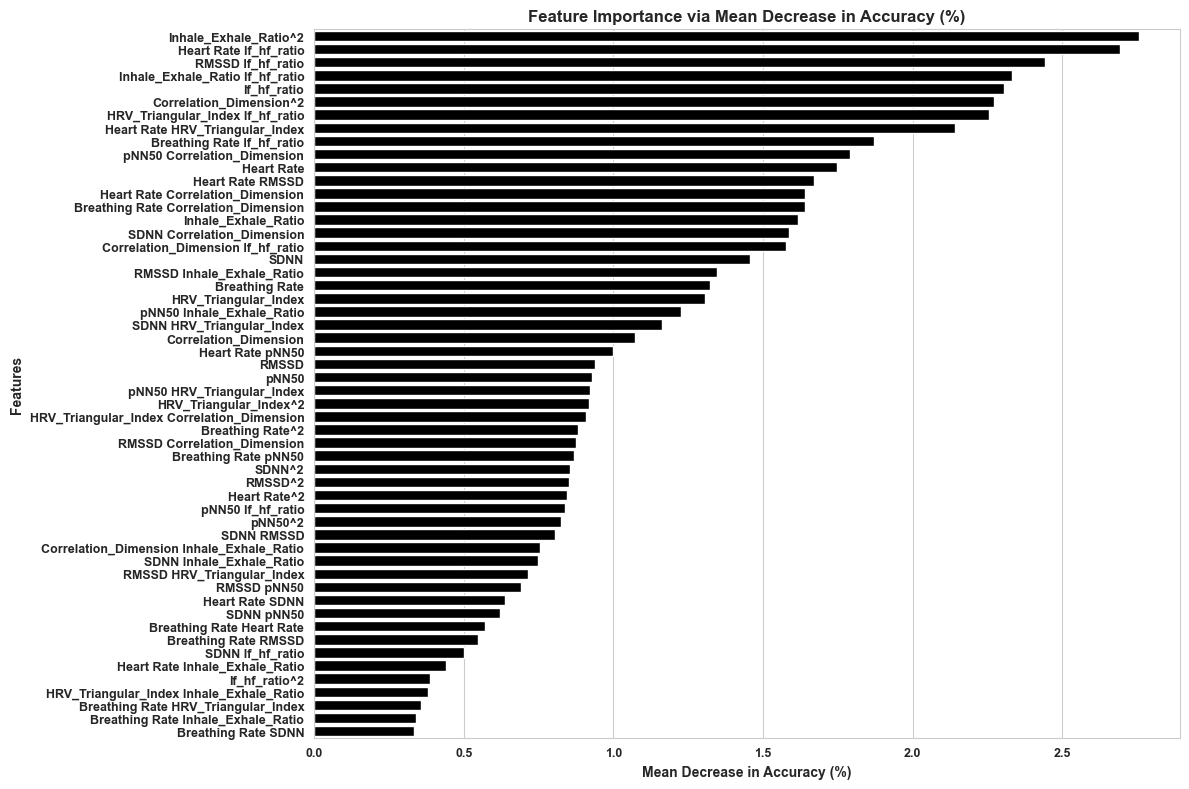

Top 10 Features by Mean Decrease in Accuracy:
                             Feature  MDA Percentage
51             Inhale_Exhale_Ratio^2        2.755874
25            Heart Rate lf_hf_ratio        2.692657
38                 RMSSD lf_hf_ratio        2.440892
52   Inhale_Exhale_Ratio lf_hf_ratio        2.333285
8                        lf_hf_ratio        2.304840
48           Correlation_Dimension^2        2.273546
47  HRV_Triangular_Index lf_hf_ratio        2.255703
22   Heart Rate HRV_Triangular_Index        2.140400
17        Breathing Rate lf_hf_ratio        1.871990
41       pNN50 Correlation_Dimension        1.792488


In [28]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'merged_hrv_features_latest.csv'
data = pd.read_csv(file_path)

# Clean column names
data.columns = data.columns.str.strip()

# Select features and target variable
features = data[['Breathing Rate', 'Heart Rate', 'SDNN', 'RMSSD', 'pNN50',
                 'HRV_Triangular_Index', 'Correlation_Dimension', 'Inhale_Exhale_Ratio', 'lf_hf_ratio']]
target = data['CGM']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)
target_imputed = target.fillna(target.mean())

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

# Temporal augmentation function
def temporal_augmentation(data, window_size=5, step_size=1):
    augmented_data = []
    for start in range(0, len(data) - window_size + 1, step_size):
        window = data[start:start + window_size]
        augmented_data.append(np.mean(window, axis=0))
    return np.array(augmented_data)

# Apply temporal augmentation
window_size = 5
step_size = 1
X_augmented = temporal_augmentation(features_scaled, window_size, step_size)
y_augmented = temporal_augmentation(target_imputed.values.reshape(-1, 1), window_size, step_size).flatten()

# Generate polynomial and interaction features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_aug_poly = poly.fit_transform(X_augmented)

# Split data into training and testing sets
X_train_aug_poly, X_test_aug_poly, y_train_aug_poly, y_test_aug_poly = train_test_split(
    X_aug_poly, y_augmented, test_size=0.2, random_state=42
)

# Train the full model and calculate the baseline accuracy
xgboost_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgboost_model.fit(X_train_aug_poly, y_train_aug_poly)
baseline_accuracy = xgboost_model.score(X_test_aug_poly, y_test_aug_poly)

# Calculate Mean Decrease in Accuracy (MDA)
mda_results = {}

augmented_feature_names = poly.get_feature_names_out(features.columns.tolist())

for i, feature_name in enumerate(augmented_feature_names):
    # Shuffle the values of the feature in the test set
    X_test_shuffled = X_test_aug_poly.copy()
    np.random.shuffle(X_test_shuffled[:, i])
    
    # Evaluate the model with the shuffled feature
    shuffled_accuracy = xgboost_model.score(X_test_shuffled, y_test_aug_poly)
    
    # Calculate the Mean Decrease in Accuracy as a percentage
    mda = (baseline_accuracy - shuffled_accuracy) * 100
    mda_results[feature_name] = mda

# Convert results to a DataFrame and sort by MDA
mda_df = pd.DataFrame(list(mda_results.items()), columns=['Feature', 'MDA Percentage'])
mda_df = mda_df.sort_values(by='MDA Percentage', ascending=False)

# Plot a diagonal heatmap for MDA
plt.figure(figsize=(16, 16))

# Create a diagonal matrix for the heatmap
mda_matrix = np.zeros((len(mda_df), len(mda_df)))
np.fill_diagonal(mda_matrix, mda_df['MDA Percentage'].values)

# Annotate all values with diagonal emphasis
annot_matrix = np.full_like(mda_matrix, "", dtype=object)
for i in range(len(mda_df)):
    annot_matrix[i, i] = f"{mda_df['MDA Percentage'].values[i]:.2f}%"

sns.heatmap(
    mda_matrix,
    annot=annot_matrix,
    fmt="",
    cmap="gray",  # Change to grayscale
    xticklabels=mda_df['Feature'],
    yticklabels=mda_df['Feature'],
    cbar=False,  # Disable color bar for a plain look
    linewidths=0.5,
    square=True
)

# Adjust the font size and label rotation
plt.xticks(rotation=45, ha='right', fontsize=8, fontweight="bold")
plt.yticks(fontsize=8, fontweight="bold")

# Add labels with bold formatting
plt.xlabel("Features", fontsize=10, fontweight="bold")
plt.ylabel("Features", fontsize=10, fontweight="bold")

# Add a title with bold formatting for IEEE/ACM compatibility
plt.title("Mean Decrease in Accuracy as Percentage (Diagonal-Only Emphasis)", fontsize=12, fontweight="bold")
plt.tight_layout()

# Save the figure in high resolution for IEEE/ACM templates
plt.savefig("Diagonal_MDA_Percentage_Heatmap_IEEE.png", dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

# Plot a bar plot for MDA
plt.figure(figsize=(12, 8))
sns.barplot(
    x='MDA Percentage',
    y='Feature',
    data=mda_df,
    palette=["black"],  # Convert to grayscale
    orient='h'
)
plt.title("Feature Importance via Mean Decrease in Accuracy (%)", fontsize=12, fontweight="bold")
plt.xlabel("Mean Decrease in Accuracy (%)", fontsize=10, fontweight="bold")
plt.ylabel("Features", fontsize=10, fontweight="bold")
plt.xticks(fontsize=9, fontweight="bold")
plt.yticks(fontsize=9, fontweight="bold")

# Save the bar plot in high resolution for IEEE/ACM templates
plt.tight_layout()
plt.savefig("Barplot_MDA_Percentage_IEEE_Figure9.png", dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

# Display the top 10 features with the highest MDA
print("Top 10 Features by Mean Decrease in Accuracy:")
print(mda_df.head(10))


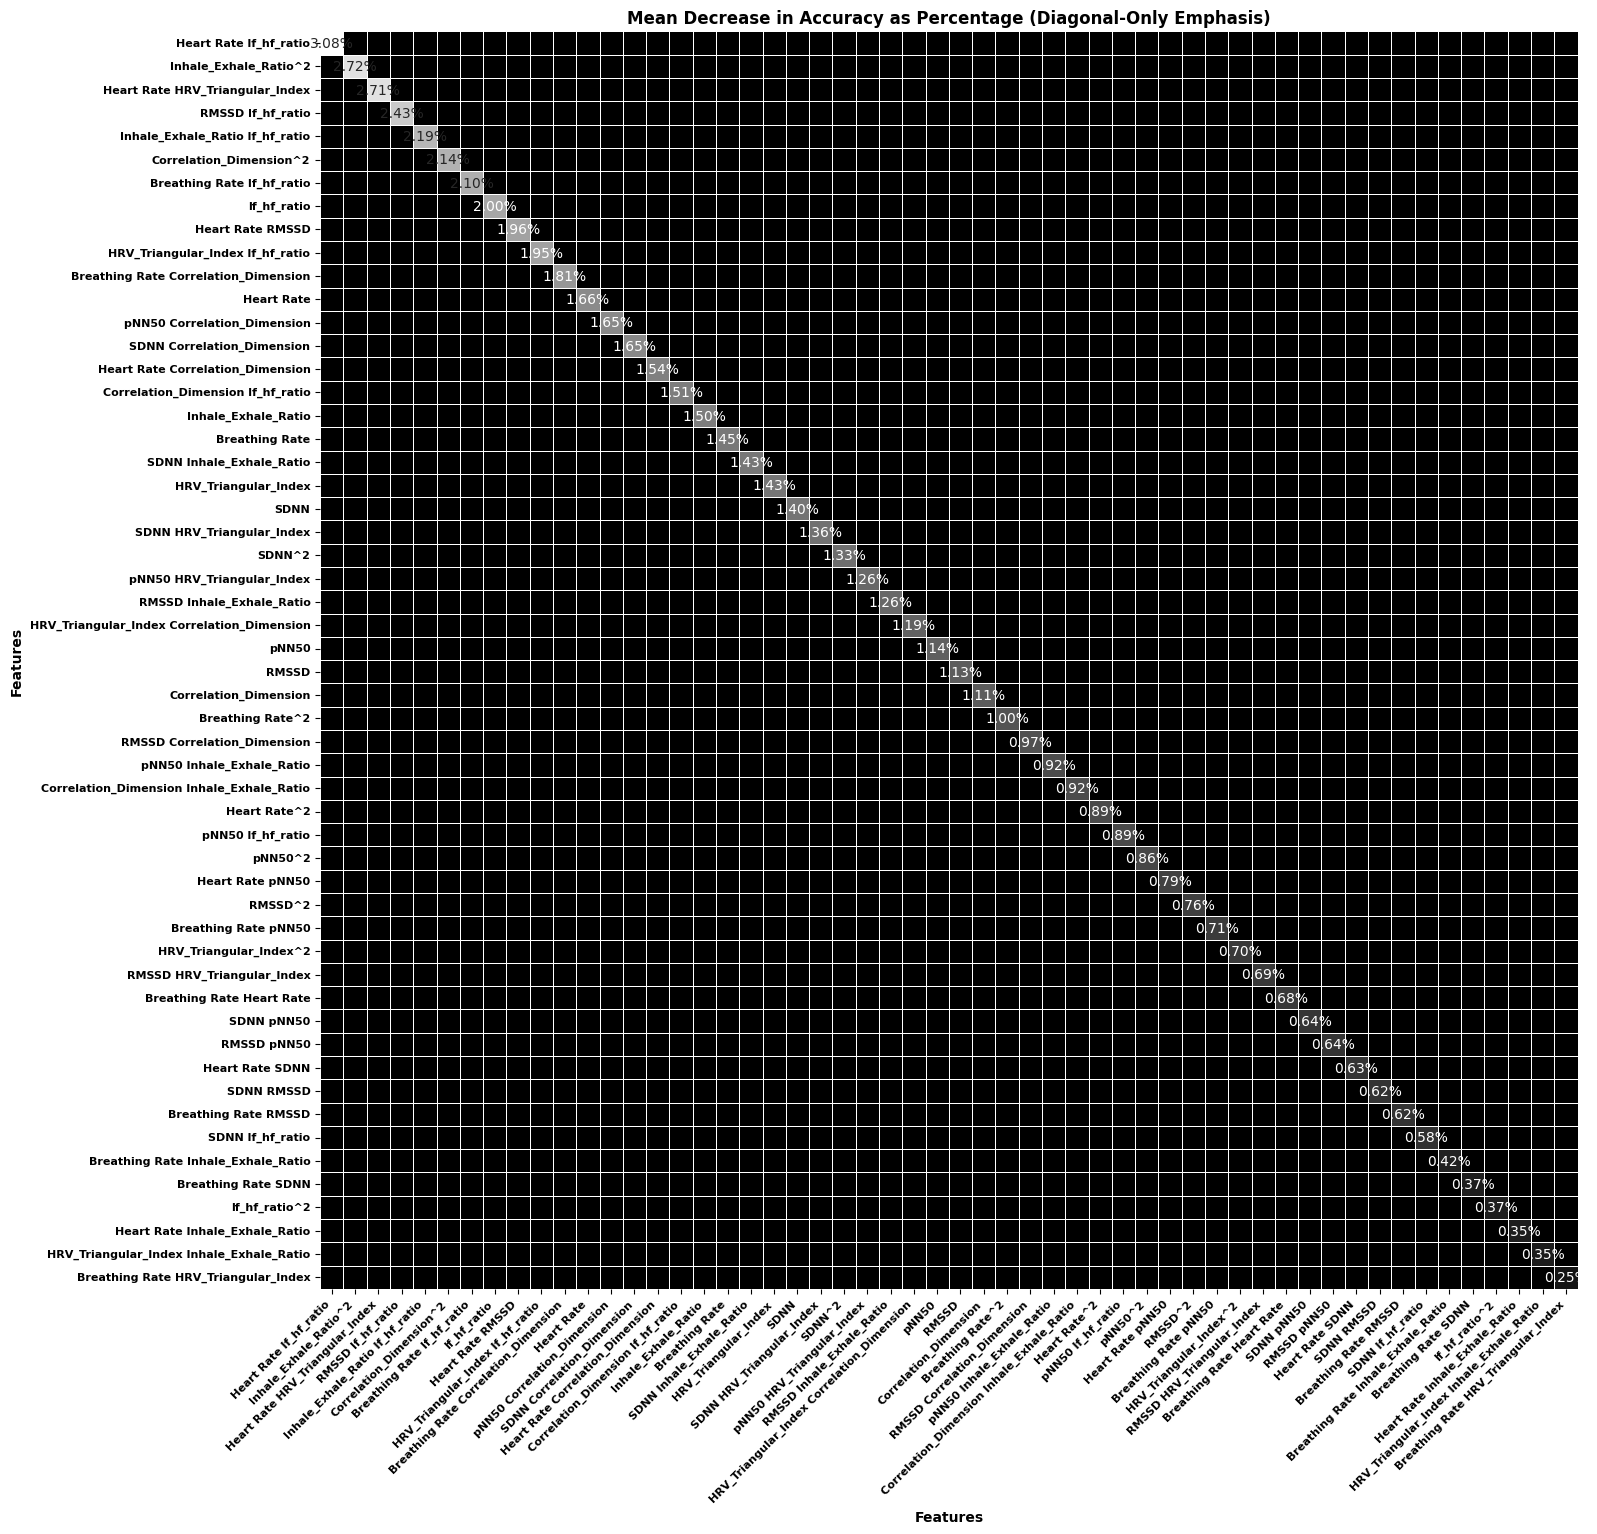

C:\Users\hp\AppData\Local\Temp\ipykernel_19088\1712046103.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


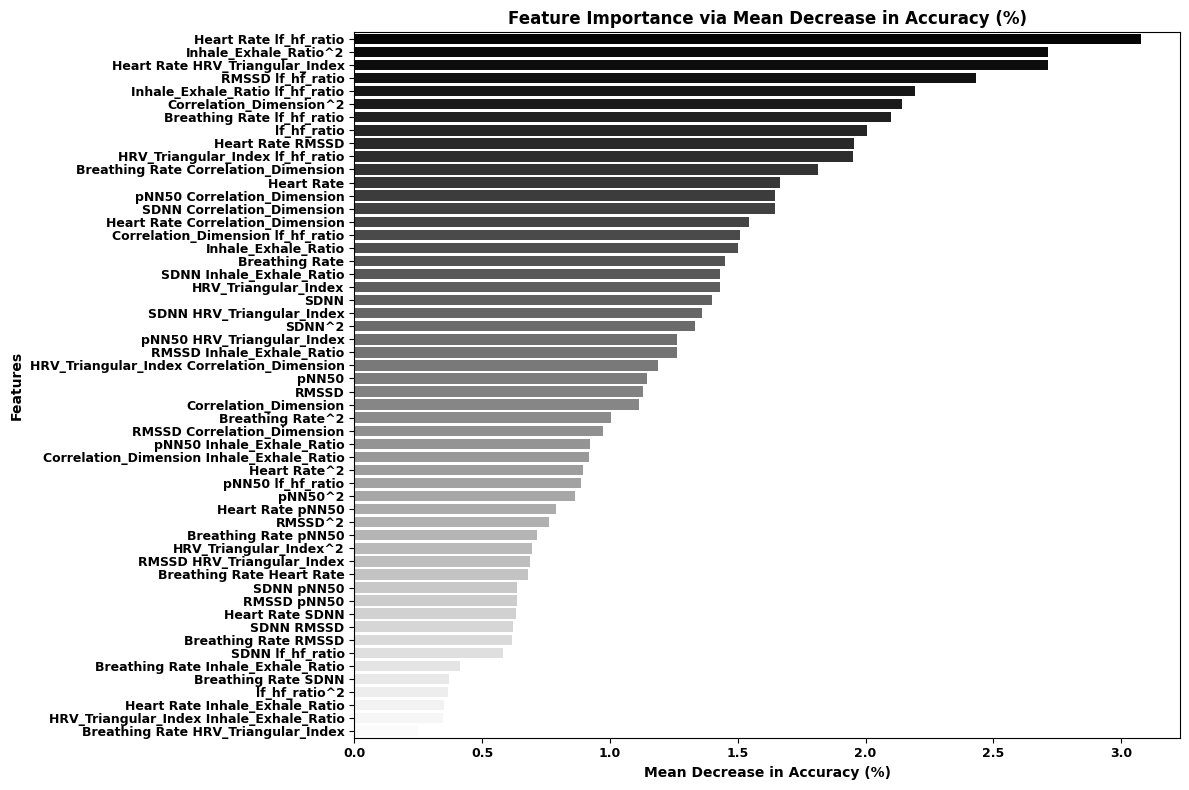

Top 10 Features by Mean Decrease in Accuracy:
                             Feature  MDA Percentage
25            Heart Rate lf_hf_ratio        3.075846
51             Inhale_Exhale_Ratio^2        2.715146
22   Heart Rate HRV_Triangular_Index        2.714308
38                 RMSSD lf_hf_ratio        2.432130
52   Inhale_Exhale_Ratio lf_hf_ratio        2.194998
48           Correlation_Dimension^2        2.142503
17        Breathing Rate lf_hf_ratio        2.100719
8                        lf_hf_ratio        2.004205
20                  Heart Rate RMSSD        1.955959
47  HRV_Triangular_Index lf_hf_ratio        1.951355


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'merged_hrv_features_latest.csv'
data = pd.read_csv(file_path)

# Clean column names
data.columns = data.columns.str.strip()

# Select features and target variable
features = data[['Breathing Rate', 'Heart Rate', 'SDNN', 'RMSSD', 'pNN50',
                 'HRV_Triangular_Index', 'Correlation_Dimension', 'Inhale_Exhale_Ratio', 'lf_hf_ratio']]
target = data['CGM']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)
target_imputed = target.fillna(target.mean())

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

# Temporal augmentation function
def temporal_augmentation(data, window_size=5, step_size=1):
    augmented_data = []
    for start in range(0, len(data) - window_size + 1, step_size):
        window = data[start:start + window_size]
        augmented_data.append(np.mean(window, axis=0))
    return np.array(augmented_data)

# Apply temporal augmentation
window_size = 5
step_size = 1
X_augmented = temporal_augmentation(features_scaled, window_size, step_size)
y_augmented = temporal_augmentation(target_imputed.values.reshape(-1, 1), window_size, step_size).flatten()

# Generate polynomial and interaction features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_aug_poly = poly.fit_transform(X_augmented)

# Split data into training and testing sets
X_train_aug_poly, X_test_aug_poly, y_train_aug_poly, y_test_aug_poly = train_test_split(
    X_aug_poly, y_augmented, test_size=0.2, random_state=42
)

# Train the full model and calculate the baseline accuracy
xgboost_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgboost_model.fit(X_train_aug_poly, y_train_aug_poly)
baseline_accuracy = xgboost_model.score(X_test_aug_poly, y_test_aug_poly)

# Calculate Mean Decrease in Accuracy (MDA)
mda_results = {}

augmented_feature_names = poly.get_feature_names_out(features.columns.tolist())

for i, feature_name in enumerate(augmented_feature_names):
    # Shuffle the values of the feature in the test set
    X_test_shuffled = X_test_aug_poly.copy()
    np.random.shuffle(X_test_shuffled[:, i])
    
    # Evaluate the model with the shuffled feature
    shuffled_accuracy = xgboost_model.score(X_test_shuffled, y_test_aug_poly)
    
    # Calculate the Mean Decrease in Accuracy as a percentage
    mda = (baseline_accuracy - shuffled_accuracy) * 100
    mda_results[feature_name] = mda

# Convert results to a DataFrame and sort by MDA
mda_df = pd.DataFrame(list(mda_results.items()), columns=['Feature', 'MDA Percentage'])
mda_df = mda_df.sort_values(by='MDA Percentage', ascending=False)

# Plot a diagonal heatmap for MDA in black and white
plt.figure(figsize=(16, 16))

# Create a diagonal matrix for the heatmap
mda_matrix = np.zeros((len(mda_df), len(mda_df)))
np.fill_diagonal(mda_matrix, mda_df['MDA Percentage'].values)

# Annotate all values with diagonal emphasis
annot_matrix = np.full_like(mda_matrix, "", dtype=object)
for i in range(len(mda_df)):
    annot_matrix[i, i] = f"{mda_df['MDA Percentage'].values[i]:.2f}%"

sns.heatmap(
    mda_matrix,
    annot=annot_matrix,
    fmt="",
    cmap="gray",  # Black and white colormap
    xticklabels=mda_df['Feature'],
    yticklabels=mda_df['Feature'],
    cbar=False,  # Disable color bar for a plain look
    linewidths=0.5,
    square=True
)

# Adjust the font size and label rotation
plt.xticks(rotation=45, ha='right', fontsize=8, fontweight="bold")
plt.yticks(fontsize=8, fontweight="bold")

# Add a title with bold formatting for IEEE compatibility
plt.title("Mean Decrease in Accuracy as Percentage (Diagonal-Only Emphasis)", fontsize=12, fontweight="bold")
plt.xlabel("Features", fontsize=10, fontweight="bold")
plt.ylabel("Features", fontsize=10, fontweight="bold")
plt.tight_layout()

# Save the figure in high resolution for IEEE templates
plt.savefig("Diagonal_MDA_Percentage_Heatmap_IEEE.png", dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

# Plot a bar plot for MDA in black and white
plt.figure(figsize=(12, 8))
sns.barplot(
    x='MDA Percentage',
    y='Feature',
    data=mda_df,
    palette="gray",  # Black and white color palette
    orient='h'
)
plt.title("Feature Importance via Mean Decrease in Accuracy (%)", fontsize=12, fontweight="bold")
plt.xlabel("Mean Decrease in Accuracy (%)", fontsize=10, fontweight="bold")
plt.ylabel("Features", fontsize=10, fontweight="bold")
plt.xticks(fontsize=9, fontweight="bold")
plt.yticks(fontsize=9, fontweight="bold")

# Save the bar plot in high resolution for IEEE templates
plt.tight_layout()
plt.savefig("Barplot_MDA_Percentage_IEEE.png", dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

# Display the top 10 features with the highest MDA
print("Top 10 Features by Mean Decrease in Accuracy:")
print(mda_df.head(10))
